# Exploratory Data Analysis
This notebook will explore the FieldPlant dataset as downloaded from RoboFlow.com (https://universe.roboflow.com/plant-disease-detection/fieldplant)

# Module Imports
Import required modules for this notebook.

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from ast import literal_eval
from collections import Counter

from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

import numpy as np
import copy
from PIL import Image
import pathlib
import imagesize
import random
import seaborn as sns


2024-09-17 14:15:43.846927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 14:15:45.546639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Runtime Configuration
Tensorflow configuration to optimize GPU memory utilisation.<br>
https://www.tensorflow.org/guide/gpu

In [2]:
def set_memory_growth():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

def set_memory_limit(memory_limit):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus: 
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=memory_limit)]
        )
    
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

keras.mixed_precision.set_global_policy("mixed_float16")
pd.set_option('display.max_columns', None)

home = os.environ['HOME']
local = True if "ruairi" in home else False

if local:
    set_memory_limit(4096)
    #set_memory_growth()

1 Physical GPU, 1 Logical GPUs


2024-09-17 14:15:50.635222: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 14:15:50.910993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 14:15:50.911185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 14:15:50.914688: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-17 14:15:50.914791: I external/local_xla/xla/stream_executor

# Hyperparameters
These hyperparameteres are declared at the start of the notebook, to be used throughout.

In [3]:
IMG_DIM = 299
IMG_SIZE = (IMG_DIM, IMG_DIM)
AUTOTUNE = tf.data.AUTOTUNE
TRAIN_PC = 0.8
TEST_VAL_PC = 1 - TRAIN_PC
TEST_PC = np.round((TEST_VAL_PC / 2), 2)
VAL_PC = copy.deepcopy(TEST_PC)
SEED = 100

# Functions
Functions to be used in the processing of data below. Some are custom made, others are taken from tutorials.<br>
- get_disease_name: identifies the class columns that have a value of 1, to indicate the classes of the sample. <br>
- get_crop_name: Extracts the crop name from the list of disease names identified in the sample.<br>
- dataset_from_dataframe: Creates a TF dataset of filenames and disease labels from a Pandas DataFrame.<br>
- decode_img: Converts an image filepath name of a jpeg file to a tensor of pixels. (https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control)<br>
- process_dataset: parent function to process image file and return dataset of pixels and labels.<br>
- verify_dataset: function to visualise the images and their corresponding labels.  Also takes label name from the dataframe that corresponds with the filename.  Used to verify that the labels match the correct image.  The image to filename is then verified manually by opening the image file in the desktop to ensure it matches.

In [4]:
def get_disease_names(row):
    diseases_bool = row == 1
    diseases = diseases_bool.index[diseases_bool].tolist()
    return diseases

def get_crop_name(disease_list):
    first_words = []
    for disease in disease_list:
        first_word = disease.split()[0]
        if first_word not in first_words:
            first_words.append(first_word)
    return first_words
    
def dataset_from_dataframe(dataframe, class_names):
    img = dataframe.filename
    labels = dataframe[class_names]
    return tf.data.Dataset.from_tensor_slices((img, labels))

def decode_img(filename, img_size):
    img_dir = "../data/images/"
    filepath = img_dir + filename
    img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    return img
   
def process_dataset(filename, labels, img_size=IMG_SIZE, return_filenames=False):
    img = decode_img(filename, img_size=img_size)
    if return_filenames:
        return img, labels, filename
    else:
        return img, labels

def verify_dataset(dataset, num_verify=2):
    plt.figure(figsize=(5, 5*num_verify))
    for i, (img, label_binary_codes, filename) in enumerate(dataset.take(num_verify)):
        ax = plt.subplot(num_verify, 1, i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        label_int_codes_from_ds = [i for i, val in enumerate(label_binary_codes) if val != 0]
        labels_names_from_ds = [class_names[i] for i in label_int_codes_from_ds]

        labels_from_filename = df.Diseases[df.filename == filename].values

        filename = filename.numpy().decode("utf-8").split("/")[-1]

        print(f"Filename from ds: {filename}")
        print(f"Label from ds: {labels_names_from_ds}")
        print(f"Label from df: {labels_from_filename}")
        print()
        plt.title(filename)
        plt.axis("off")

In [5]:
df = pd.read_csv("../data/csv_files/classes_processed.csv")
num_labels = df.iloc[:, 1:-2].sum().sum()

***
***
***

# Inspect Dataset

"classes.csv" is provided with the image data. Dataframe of binary encoded class labels.  A sinlge image may have more than one disease class.<br>
This dataset has 5156 rows and 28 columns.  1 column is the filename, so there are 27 disease classes.

In [6]:
csv_path = "../data/csv_files/classes.csv"
df = pd.read_csv(csv_path).sort_values(by="filename").reset_index(drop=True)
print(df.shape)
print(df.columns[:3])
df.head(3)

(5156, 28)
Index(['filename', ' Cassava Bacterial Blight', ' Cassava Brown Leaf Spot'], dtype='object')


,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Charcoal,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,Corn Healthy,Corn Insects Damages,Corn Mildew,Corn Purple Discoloration,Corn Smut,Corn Streak,Corn Stripe,Corn Violet Decoloration,Corn Yellow Spots,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato bacterial wilt,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus
0,Charbon_de_mais-1-_jpg.rf.d83e40544e3be2dac4fd...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Charbon_de_mais-2-_jpg.rf.e2c36854e8f83c0f5cdd...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Charbon_de_mais-3-_jpg.rf.7779b177d76937957b47...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Strip surrounding white space from columns.<br>
Create new column of disease names, from the binary encoded labels.<br>
Create new column of crop names from the disease names lists.


In [7]:
df.columns = df.columns.str.strip()
class_names = df.columns[1:]
df['Diseases'] = df.apply(get_disease_names, axis=1)
df['Crops'] = df.Diseases.apply(get_crop_name)
print(df.shape)
df.head(3)

(5156, 30)


,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Charcoal,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,Corn Healthy,Corn Insects Damages,Corn Mildew,Corn Purple Discoloration,Corn Smut,Corn Streak,Corn Stripe,Corn Violet Decoloration,Corn Yellow Spots,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato bacterial wilt,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus,Diseases,Crops
0,Charbon_de_mais-1-_jpg.rf.d83e40544e3be2dac4fd...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,[Corn Smut],[Corn]
1,Charbon_de_mais-2-_jpg.rf.e2c36854e8f83c0f5cdd...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,[Corn Smut],[Corn]
2,Charbon_de_mais-3-_jpg.rf.7779b177d76937957b47...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,[Corn Smut],[Corn]


### Save Dataframe

In [8]:
csv_path = "../data/csv_files/classes_processed.csv"
df.to_csv(csv_path, index=False)

***
***
***

### Filenames
##### Check Duplicates
There are no duplicate filenames in this dataframe.  There will be duplicate values in the disease class columns, so this is not checked.

In [9]:
df.filename.duplicated().sum()

0

##### Check that filenames in csv match filenames in image folder
Get list of filenames in images dir with Path.<br>
Compare to images in dataframe, and check that all comparisons are true.

In [10]:
images_dir = pathlib.Path("../data/images/")
filenames_in_dir = sorted([str(f).split("/")[-1] for f in images_dir.glob("*.jpg")])
np.all(filenames_in_dir == df.filename)

True

***
***
***

### Disease Classes

##### Number of disease classes per sample
There are a total of 5346 annotations for diseases, acros 5156 images.<br>
Most images contain only 1 disease per image.<br>
There is only 1 sample that contains 3 disease states, that is a Tomato plant sample.<br>

In [11]:
sum_of_disease_cols = df.sum(numeric_only=True, axis=1).sum()
print(f"Number of total annotated diseases: {sum_of_disease_cols}")
print()
print(f"Number of images with given number of diseases:")
df.sum(numeric_only=True, axis=1).value_counts()

Number of total annotated diseases: 5346

Number of images with given number of diseases:


1    4967
2     188
3       1
Name: count, dtype: int64

In [12]:
sample_with_3 = df[df.Diseases.apply(lambda x: len(x)) == 3]
print(sample_with_3.Diseases.values)
sample_with_3

[list(['Tomato blight leaf', 'Tomato healthy', 'Tomato leaf yellow virus'])]


,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Charcoal,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,Corn Healthy,Corn Insects Damages,Corn Mildew,Corn Purple Discoloration,Corn Smut,Corn Streak,Corn Stripe,Corn Violet Decoloration,Corn Yellow Spots,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato bacterial wilt,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus,Diseases,Crops
368,IMG_20221118_081835_744_jpg.rf.33cfed71f73ac3e...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,"[Tomato blight leaf, Tomato healthy, Tomato le...",[Tomato]


##### Individual Disease value counts
There are 2 disease classes which contain only 1 sample per class.<br>
This will make it difficut to train a model on this disease class.

In [13]:
a = df[class_names].sum().sort_values().to_frame().rename(columns={0:"count"})
a["pc"] = a["count"] / a["count"].sum() * 100
a

,count,pc
Tomato bacterial wilt,1,0.018706
Corn Charcoal,1,0.018706
Corn Violet Decoloration,6,0.112233
Corn Purple Discoloration,8,0.149645
Corn Smut,13,0.243172
Tomato leaf mosaic virus,13,0.243172
Corn Yellow Spots,16,0.299289
Corn Insects Damages,17,0.317995
Cassava Bacterial Blight,22,0.411523
Corn Chlorotic Leaf Spot,26,0.486345


***
***
***

### Crop Classes
The distribution of crop counts is shown below.  Only 1 sample has 2 crops in it.<br>
This sample contains both Cassava and Corn.

In [14]:
crops_df = df.Crops.to_frame()
print(crops_df.Crops.value_counts())
print()

crops_df["Corn"] = crops_df.Crops.apply(lambda x: "Corn" in x)
crops_df["Cassava"] = crops_df.Crops.apply(lambda x: "Cassava" in x)
crops_df["Tomato"] = crops_df.Crops.apply(lambda x: "Tomato" in x)
crops_df = crops_df.drop(columns="Crops")
# num_crop_annotations = crops_df.sum(numeric_only=True).sum()
# print(f"Number of crop annotations: {num_crop_annotations}")
# crops_df.sum(numeric_only=True)
b = crops_df.sum().sort_values().to_frame().rename(columns={0:"count"})
b["pc"] = b["count"] / b["count"].sum() * 100
b

Crops
[Corn]             2150
[Cassava]          1602
[Tomato]           1403
[Cassava, Corn]       1
Name: count, dtype: int64



,count,pc
Tomato,1403,27.205740
Cassava,1603,31.083964
Corn,2151,41.710297


In [15]:
df[df.Crops.apply(lambda x: len(x)) == 2]

,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Charcoal,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,Corn Healthy,Corn Insects Damages,Corn Mildew,Corn Purple Discoloration,Corn Smut,Corn Streak,Corn Stripe,Corn Violet Decoloration,Corn Yellow Spots,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato bacterial wilt,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus,Diseases,Crops
3943,Manioc_Taches-Brunes_-13-_jpg.rf.9d1d3b649e393...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[Cassava Healthy, Corn Brown Spots]","[Cassava, Corn]"


***
***
***

### Visualise value counts
The point at which the bars become practically invisible, is when there is only 1 sample per class.

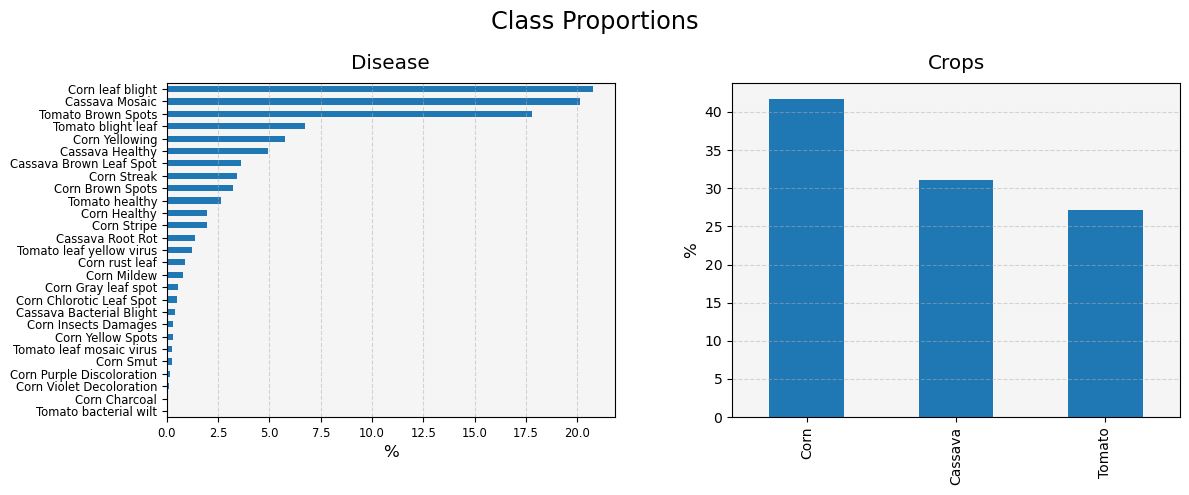

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
diseases = df[class_names].sum().to_frame()
diseases["pc"] = diseases / diseases.sum() * 100
diseases.pc.sort_values(ascending=True).plot(ax=ax1, kind="barh", x="Disease", fontsize="small");
ax1.grid(axis="x", linestyle="--", alpha=0.5)
ax1.set_title("Disease", fontsize="x-large", pad=10)
ax1.set_xlabel("%", fontsize="large")
ax1.set_facecolor("whitesmoke")

crops = crops_df.sum().to_frame()
crops["pc"] = crops / crops.sum() * 100
crops.pc.sort_values(ascending=False).plot(ax=ax2, kind="bar");
ax2.grid(axis="y", linestyle="--", alpha=0.5)
ax2.set_title("Crops", fontsize="x-large", pad=10)
ax2.set_ylabel("%", fontsize="large")
ax2.set_facecolor("whitesmoke")


fig.suptitle("Class Proportions", fontsize="xx-large");
plt.tight_layout(h_pad=5, w_pad=5)

***
***
***

### Image Sizes
The following code section was adapted from the tutorial below:<br>
https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05

The majority of image sizes are above approx 2000 pixles, height and width, however have varying aspect ratios.<br>

In [17]:
# Get the Image Resolutions
images_idr = "../data/images/"
imgs = [img.name for img in pathlib.Path(images_idr).iterdir() if img.suffix == ".jpg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(images_idr+f)

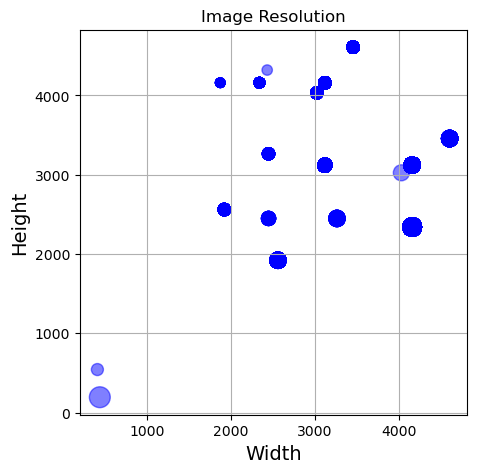

In [18]:
# Convert dictionary to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns')
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

# Visualize Image Resolutions
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14);
ax.grid()

In [19]:
dims = img_meta_df.iloc[:, 2:]
dims.describe()

,Width,Height,Aspect Ratio
count,5156.000000,5156.000000,5156.000000
mean,3216.407099,3569.771722,0.939484
std,508.154560,732.655910,0.259773
min,407.000000,193.000000,0.450000
25%,3120.000000,3120.000000,0.750000
50%,3120.000000,3120.000000,1.000000
75%,3456.000000,4160.000000,1.000000
max,4608.000000,4608.000000,2.260000


In [20]:
print(dims.median())

Width           3120.0
Height          3120.0
Aspect Ratio       1.0
dtype: float64


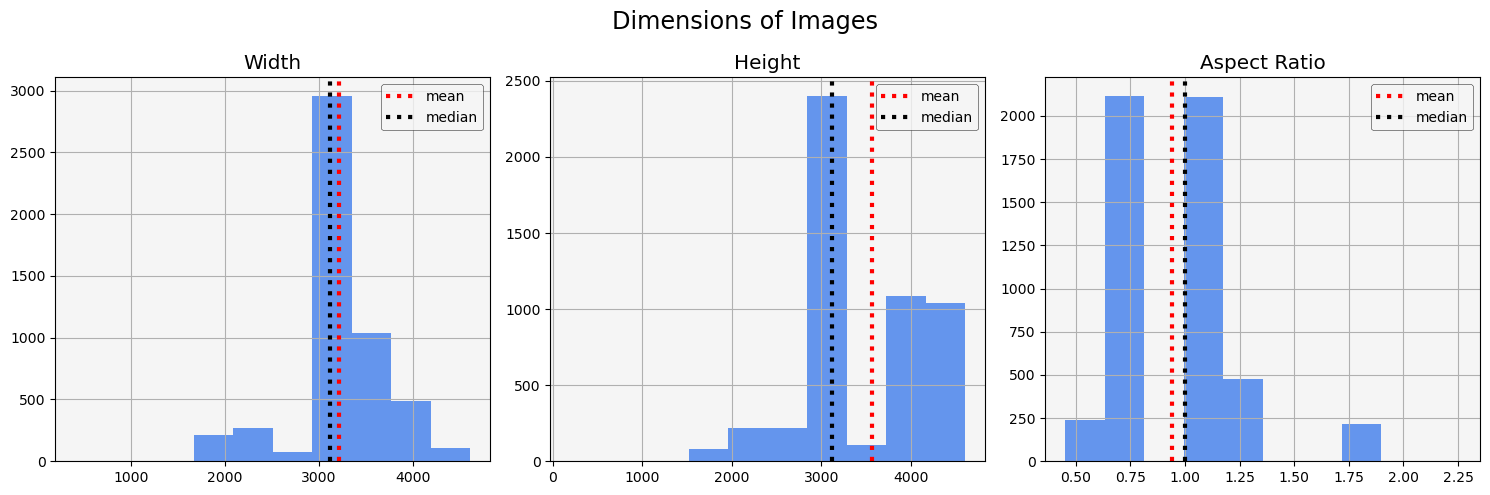

In [75]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
for i, ax in enumerate(axes):
    data = dims.iloc[:,i]
    ax.hist(data, color="cornflowerblue")
    ax.grid()
    ax.set_title(dims.columns[i], fontsize="x-large")
    ax.axvline(data.mean(), c="red", linestyle=":", label="mean", lw=3)
    ax.axvline(data.median(), c="black", linestyle=":", label="median", lw=3)
    ax.set_facecolor("whitesmoke")
    leg = ax.legend(facecolor="whitesmoke")
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(0.4)
fig.suptitle("Dimensions of Images", fontsize="xx-large")
fig.tight_layout()

##### Small Image Size
There are 2 images with dimensions each of < 1000 pixels.  They both belong to the Cassava Root Rot class.<br>
This low resolution could impact the image classification, however there are a total of 74 images in this class, so the other images will be able to provide higher resolution samples.

In [21]:
img_meta_df[img_meta_df.Width < 1000]

,FileName,Size,Width,Height,Aspect Ratio
3937,Manioc_Pourriture-Tubercules_-1-_png.rf.bcc2fc...,"(436, 193)",436,193,2.26
3938,Manioc_Pourriture-Tubercules_-2-_png.rf.ff6cee...,"(407, 542)",407,542,0.75


In [22]:
df[df.apply(lambda row: row.filename in img_meta_df[img_meta_df.Width < 1000].FileName.values, axis=1)]

,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Charcoal,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,Corn Healthy,Corn Insects Damages,Corn Mildew,Corn Purple Discoloration,Corn Smut,Corn Streak,Corn Stripe,Corn Violet Decoloration,Corn Yellow Spots,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato bacterial wilt,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus,Diseases,Crops
3937,Manioc_Pourriture-Tubercules_-1-_png.rf.bcc2fc...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[Cassava Root Rot],[Cassava]
3938,Manioc_Pourriture-Tubercules_-2-_png.rf.ff6cee...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[Cassava Root Rot],[Cassava]


In [23]:
df["Cassava Root Rot"].sum()

74

In [24]:
df_resolution = df.merge(img_meta_df, left_on="filename", right_on="FileName", how="outer")
df_resolution["Aspect Ratio"].value_counts()

Aspect Ratio
0.75    2118
1.00    2108
1.33     474
1.78     216
0.56     207
0.45      32
2.26       1
Name: count, dtype: int64

In [25]:
df_resolution.Diseases = df_resolution.Diseases.astype(str)

##### Mean Height/Width per Class
The mean pixel height and width per class is displayed below.<br>

In [75]:
df_resolution.groupby("Diseases").agg({"Height":"mean", "Width":"mean"}).sort_values("Height")

,Height,Width
Diseases,,
"['Tomato blight leaf', 'Tomato healthy', 'Tomato leaf yellow virus']",1920.000000,2560.000000
"['Corn Streak', 'Corn Stripe']",2448.000000,2448.000000
"['Tomato blight leaf', 'Tomato healthy']",2608.881890,2256.503937
['Tomato healthy'],2781.538462,2830.769231
['Tomato blight leaf'],3003.428571,2549.818182
"['Cassava Brown Leaf Spot', 'Cassava Healthy']",3120.000000,3120.000000
"['Cassava Healthy', 'Corn Brown Spots']",3120.000000,3120.000000
"['Corn Brown Spots', 'Corn Healthy']",3120.000000,3120.000000
"['Corn Stripe', 'Corn leaf blight']",3120.000000,3120.000000


***
***
***
***
***

# Create Dataset
Import the processed dataset created above.<br>
Creates tensor of image pixels and respective binary label codes.<br>
Processed csv file is imported.

In [76]:
csv_path = "../data/csv_files/classes_processed.csv"
df = pd.read_csv(csv_path).sort_values(by="filename").reset_index(drop=True)
df.Diseases = df.Diseases.apply(lambda x: literal_eval(x))
class_names = df.columns[1:-2]
print(df.shape)

(5156, 30)


dataset_from_dataframe custom function, takes a dataframe and returns a Tensorflow dataset of file names and binary encoded labels.

In [77]:
ds_filenames = dataset_from_dataframe(df, class_names)
ds_filenames = ds_filenames.shuffle(ds_filenames.cardinality(), seed=SEED)

for x, y in ds_filenames.take(1):
    print(x)
    print(y)

tf.Tensor(b'Mais_Mildiou_-185-_jpg.rf.3289712c8a57fa74fe9d55b3df948533.jpg', shape=(), dtype=string)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0], shape=(27,), dtype=int64)


2024-08-29 16:22:15.105757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Verify Labels
The process_dataset function returns the image pixels, the label codes, and the original filename.<br>
The filename is returned so that the labels and images can be verified to be correct, by comparing the label in the dataset to the label in the dataframe.<br>
The image is verified to be correct by manually checking the jpeg file.<br>
The dataset is shuffled so as to verify a new set of images each time, and this process is repeated several times until satisfied. It is shuffle using a small buffer size as to completely randomise the dataset is not necessary at this point.

2024-08-29 16:22:15.463676: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29203200 exceeds 10% of free system memory.
2024-08-29 16:22:15.463946: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29203200 exceeds 10% of free system memory.
2024-08-29 16:22:15.470485: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38937600 exceeds 10% of free system memory.
2024-08-29 16:22:15.487143: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23362560 exceeds 10% of free system memory.
2024-08-29 16:22:15.487612: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29203200 exceeds 10% of free system memory.
2024-08-29 16:22:25.423298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 339 of 644
2024-08-29 16:22:30.583659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buf

Filename from ds: IMG20221216160030_jpg.rf.cb27192607f287b46983a58a8615a8e5.jpg
Label from ds: ['Corn leaf blight']
Label from df: [list(['Corn leaf blight'])]

Filename from ds: Manioc_Taches_Brunes-19-_jpg.rf.0f5ca6d9d0dc00dbd67923ff18ef4cb1.jpg
Label from ds: ['Cassava Brown Leaf Spot']
Label from df: [list(['Cassava Brown Leaf Spot'])]

Filename from ds: Manioc_Mosaique-202-_jpg.rf.3f82f868782a55164657ef33207f74ad.jpg
Label from ds: ['Cassava Mosaic']
Label from df: [list(['Cassava Mosaic'])]

Filename from ds: Manioc_Bacteriose-92-_jpg.rf.3a843ee4caa8b52a4123ab185c42c343.jpg
Label from ds: ['Cassava Root Rot']
Label from df: [list(['Cassava Root Rot'])]



2024-08-29 16:22:36.613741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


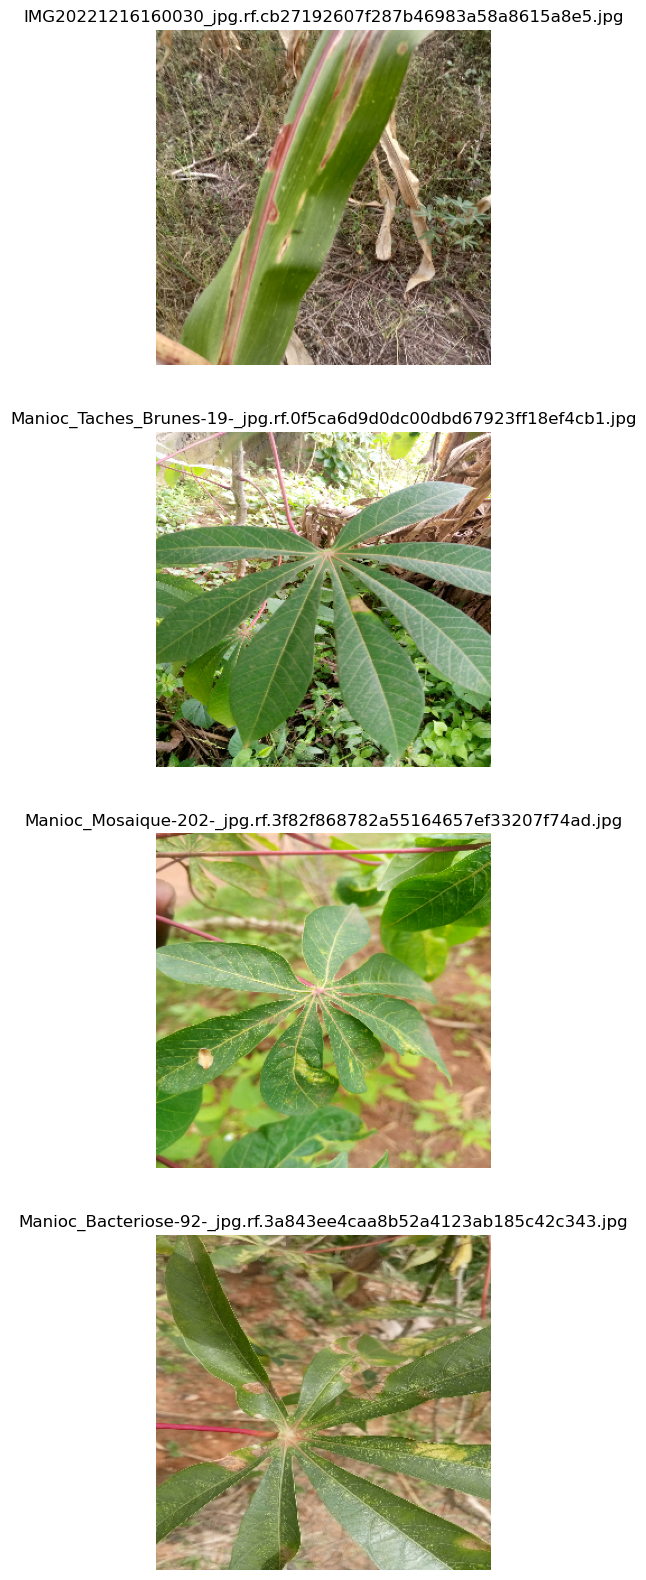

In [78]:
ds_verify = ds_filenames.map(lambda x, y: process_dataset(x, y, return_filenames=True) , num_parallel_calls=AUTOTUNE)
ds_verify = ds_verify.shuffle(buffer_size=ds_verify.cardinality() // 8, seed=SEED)
verify_dataset(ds_verify, num_verify=4)

### Full Dataset
After verification, the full dataset is created again however the filenames are not returned, so the dataset just consists of the image pixels and their labels.<br>
The dataset is shuffled using a buffer size the same size as the dataset itself, so as to ensure true full randomisation. https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle <br>
The shape of the image pixels tensor and labels are inspected.<br>


In [79]:
ds = ds_filenames.map(lambda x, y: process_dataset(x, y, return_filenames=False) , num_parallel_calls=AUTOTUNE)
ds = ds.shuffle(buffer_size=ds.cardinality(), seed=SEED)

In [80]:
for x, y in ds.take(1):
    print(x)
    print(y)

2024-08-29 16:22:47.452259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1253 of 5156
2024-08-29 16:22:57.476013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2418 of 5156
2024-08-29 16:23:17.441242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 4972 of 5156


tf.Tensor(
[[[154.47116  208.47116  174.47116 ]
  [152.87004  207.52269  167.34735 ]
  [143.47827  196.47827  154.47827 ]
  ...
  [131.16586  186.16586  154.16586 ]
  [133.28093  188.28093  157.12883 ]
  [131.56543  186.56543  155.56543 ]]

 [[125.95321  180.95322  140.97447 ]
  [138.77127  194.18573  150.0293  ]
  [138.25613  191.25613  149.25613 ]
  ...
  [134.36005  189.6644   157.51222 ]
  [137.31352  192.35982  161.18457 ]
  [136.73868  191.73868  160.73868 ]]

 [[133.60066  188.60066  146.60066 ]
  [171.80199  226.89131  185.34782 ]
  [153.3412   208.92816  169.92816 ]
  ...
  [136.41309  193.41309  160.41309 ]
  [132.8647   188.1689   156.8647  ]
  [134.58696  189.58696  158.58696 ]]

 ...

 [[143.39636  100.39636   81.39636 ]
  [189.75371  146.75371  127.75371 ]
  [180.50046  137.50046  118.50045 ]
  ...
  [143.76074  105.76074   69.76074 ]
  [164.43007  125.72955   89.72955 ]
  [175.12419  136.29802  100.29803 ]]

 [[195.89264  151.19684  132.19684 ]
  [180.76575  135.94092  1

2024-08-29 16:23:19.014078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-29 16:23:19.055734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


##### Save datasets
This dataset is then saved as "unfiltered_full_ds", as there will be a filtered version after.

In [81]:
dataset_path = "../data/datasets/unfiltered_full_ds"
ds.save(dataset_path)

2024-08-29 16:23:29.331532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1228 of 5156
2024-08-29 16:23:49.423197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 3693 of 5156
2024-08-29 16:24:00.679417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


##### Train, Val, Test Datasets
These datasets are created from the saved Tensorflow dataset.<br>
The size of these datasets are inspected, and then the split datasets are saved for future use.<br>

In [82]:
dataset_path = "../data/datasets/unfiltered_full_ds"
ds = tf.data.Dataset.load(dataset_path)
num_samples = len(ds)

test_pc = np.round((1 - TRAIN_PC) / 2, 2)
val_pc = copy.deepcopy(test_pc)
test_size = num_samples * test_pc
val_size = num_samples * val_pc
train_size = num_samples - test_size - val_size

test_ds = ds.take(test_size)
val_ds = ds.skip(test_size).take(val_size)
train_ds = ds.skip(test_size + val_size).take(train_size)

In [83]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

4124
515
515


In [84]:
train_ds_path = "../data/datasets/unfiltered_train_ds"
train_ds.save(train_ds_path)

val_ds_path = "../data/datasets/unfiltered_val_ds"
val_ds.save(val_ds_path)

test_ds_path = "../data/datasets/unfiltered_test_ds"
test_ds.save(test_ds_path)

***
***
***
***
***

# Filtered Dataset
There are several disease classes that contain only one sample, therefore will not be able to be used in this classification task.<br>
If there is only one sample in the training set, it is not sufficient for the model to learn the distinctive characteristics of that disease.<br>
If the disease is in the test or validation set, then the model will not have seen it in the training process, and will not be able to identify it.<br>
For this reason, any disease class with only 1 sample will be dropped and a new filtered dataset created.<br>

In [85]:
csv_path = "../data/csv_files/classes_processed.csv"
df = pd.read_csv(csv_path)
df.Diseases = df.Diseases.apply(lambda x: literal_eval(x))
print(df.shape)

(5156, 30)


##### Drop Occurences with 1 sample
The code to drop the classes with only 1 sample is taken from the following tutorial.<br>
https://keras.io/examples/nlp/multi_label_classification/#perform-exploratory-data-analysis<br>

The resulting dataframe contain 5154 samples, compared to the original 5156 samples. 2 samples have been dropped.<br>
The fewest numder of samples per class is now 6.

In [86]:
disease_vc = df.sum(numeric_only=True).sort_values()
print(disease_vc)
to_drop = list(disease_vc[disease_vc == 1].index)
to_drop

Tomato bacterial wilt           1
Corn Charcoal                   1
Corn Violet Decoloration        6
Corn Purple Discoloration       8
Corn Smut                      13
Tomato leaf mosaic virus       13
Corn Yellow Spots              16
Corn Insects Damages           17
Cassava Bacterial Blight       22
Corn Chlorotic Leaf Spot       26
Corn Gray leaf spot            30
Corn Mildew                    41
Corn rust leaf                 46
Tomato leaf yellow virus       66
Cassava Root Rot               74
Corn Stripe                   104
Corn Healthy                  105
Tomato healthy                141
Corn Brown Spots              172
Corn Streak                   182
Cassava Brown Leaf Spot       192
Cassava Healthy               264
Corn Yellowing                307
Tomato blight leaf            359
Tomato Brown Spots            952
Cassava Mosaic               1077
Corn leaf blight             1111
dtype: int64


['Tomato bacterial wilt', 'Corn Charcoal']

##### Drop Cols and Rows
Columns identified above are dropped.<br>
Rows whose binary classes sum to 0 are dropped.

In [87]:
df_filtered = df.drop(columns=to_drop)
class_names = df_filtered.columns[1:-2]
df_filtered = df_filtered.loc[(df_filtered[class_names] != 0).any(axis=1)]
df_filtered.shape

(5154, 28)

In [88]:
filtered_vc = df_filtered.sum(numeric_only=True).sort_values()
print(filtered_vc.sum())
filtered_vc

5344


Corn Violet Decoloration        6
Corn Purple Discoloration       8
Corn Smut                      13
Tomato leaf mosaic virus       13
Corn Yellow Spots              16
Corn Insects Damages           17
Cassava Bacterial Blight       22
Corn Chlorotic Leaf Spot       26
Corn Gray leaf spot            30
Corn Mildew                    41
Corn rust leaf                 46
Tomato leaf yellow virus       66
Cassava Root Rot               74
Corn Stripe                   104
Corn Healthy                  105
Tomato healthy                141
Corn Brown Spots              172
Corn Streak                   182
Cassava Brown Leaf Spot       192
Cassava Healthy               264
Corn Yellowing                307
Tomato blight leaf            359
Tomato Brown Spots            952
Cassava Mosaic               1077
Corn leaf blight             1111
dtype: int64

##### Save Filtered Dataframe

In [89]:
csv_path = "../data/csv_files/classes_filtered.csv"
df_filtered.to_csv(csv_path, index=False)

***

***

***

# Create Filtered Dataset
A dataset will be created from this new filtered dataframe.<br>
This dataset is created by adapting the steps from the following tutorial.<br>
https://keras.io/examples/nlp/multi_label_classification/#use-stratified-splits-because-of-class-imbalance<br>
The train, validation and test sets are first created by splitting the dataframe.  Each is then converted to a TF Dataset using the steps from previous.

In [90]:
csv_path = "../data/csv_files/classes_filtered.csv"
df = pd.read_csv(csv_path).sort_values(by="filename").reset_index(drop=True)
df.Diseases = df.Diseases.apply(lambda x: literal_eval(x))
class_names = df.columns[1:-2]
num_classes = len(class_names)
print(f"Num classes:{num_classes}")
print(df.shape)
df.head(3)

Num classes:25
(5154, 28)


,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,Corn Healthy,Corn Insects Damages,Corn Mildew,Corn Purple Discoloration,Corn Smut,Corn Streak,Corn Stripe,Corn Violet Decoloration,Corn Yellow Spots,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus,Diseases,Crops
0,Charbon_de_mais-1-_jpg.rf.d83e40544e3be2dac4fd...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,[Corn Smut],['Corn']
1,Charbon_de_mais-2-_jpg.rf.e2c36854e8f83c0f5cdd...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,[Corn Smut],['Corn']
2,Charbon_de_mais-3-_jpg.rf.7779b177d76937957b47...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,[Corn Smut],['Corn']


##### Test, Train, Val Split
The dataframe is split using 80% for training and a combined 20% for the test and validation.<br>
The initial split is stratified by the Disease class value counts to ensure equal representation in the training and test/val split.<br>
The validation spit is then created by randomly sampling half of the test/val split without replacement, and these samples are then dropped to form the test set.<br>
The final split is 80-10-10%.<br>

ERROR:
https://stackoverflow.com/questions/74048555/how-to-resolve-this-error-keyerror-key-of-type-tuple-not-found-and-not-a-mul

In [91]:
X = df.filename.to_frame().to_numpy()
y = df[class_names].to_numpy()

##### 50% split to assess balance

In [93]:
X_train, y_train, X_test, y_test = iterative_train_test_split(X=X, y=y, test_size=0.5)
pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=2) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test, order=2) for combination in row)
}).T.fillna(0.0).T

,train,test
"(12, 12)",6.0,7.0
"(15, 15)",3.0,3.0
"(18, 18)",556.0,555.0
"(20, 20)",476.0,476.0
"(24, 24)",33.0,33.0
"(21, 21)",180.0,179.0
"(21, 22)",64.0,64.0
"(22, 22)",70.0,71.0
"(22, 24)",1.0,0.0
"(21, 24)",1.0,0.0


### Redo with 80% Training Split

In [94]:
X_train, y_train, X_test, y_test = iterative_train_test_split(X=X, y=y, test_size=0.2)

##### Recombine X and Y into Train and Test DFs

In [95]:
X_train = pd.DataFrame(X_train)
X_train.columns = ["filename"]
y_train = pd.DataFrame(y_train)
y_train.columns = class_names

X_test = pd.DataFrame(X_test)
X_test.columns = ["filename"]
y_test = pd.DataFrame(y_test)
y_test.columns = class_names

train_df = X_train.merge(y_train, left_index=True, right_index=True)
test_df = X_test.merge(y_test, left_index=True, right_index=True)

##### Split Test set into Val and Test

In [96]:
X = test_df.filename.to_frame().to_numpy()
y = test_df[class_names].to_numpy()

X_val, y_val, X_test, y_test = iterative_train_test_split(X=X, y=y, test_size=0.5)
X_val = pd.DataFrame(X_val, columns = ["filename"])
y_val = pd.DataFrame(y_val, columns = class_names)
X_test = pd.DataFrame(X_test, columns = ["filename"])
y_test = pd.DataFrame(y_test, columns = class_names)

val_df = X_val.merge(y_val, left_index=True, right_index=True)
test_df = X_test.merge(y_test, left_index=True, right_index=True)

### Verify Labels match files from original DF
##### Random Sample

In [125]:
random_sample_train = train_df.loc[random.randint(0, len(train_df)), :].to_frame().T
display(random_sample_train)
df[df.filename == random_sample_train.filename.values[0]]

,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,Corn Healthy,Corn Insects Damages,Corn Mildew,Corn Purple Discoloration,Corn Smut,Corn Streak,Corn Stripe,Corn Violet Decoloration,Corn Yellow Spots,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus
1964,Mais_brulures_feuilles-98-_jpg.rf.698931a81a97...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,Corn Healthy,Corn Insects Damages,Corn Mildew,Corn Purple Discoloration,Corn Smut,Corn Streak,Corn Stripe,Corn Violet Decoloration,Corn Yellow Spots,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus,Diseases,Crops
2495,Mais_brulures_feuilles-98-_jpg.rf.698931a81a97...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,[Corn leaf blight],['Corn']


***
***
***

### Create datasets
Datasets are created individually from the already split dataframes.<br>
The splitting was already randomly performed on the dataframe, however will be performed here again within each dataset.

##### Verify Labels
The labels and filenames to images are once again verified to be correct using the same procedure as used earlier above.

tf.Tensor(b'Mais_Jaunissement_-268-_jpg.rf.d0d83a4ff20c5f616c0b8fa7d9336d67.jpg', shape=(), dtype=string)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0], shape=(25,), dtype=int64)


2024-08-29 16:53:41.528474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Filename from ds: Manioc_Mosaique-378-_jpg.rf.3f528b4e6af21f4fe8218305d5abca7e.jpg
Label from ds: ['Cassava Mosaic']
Label from df: [list(['Cassava Mosaic'])]

Filename from ds: Mais_Jaunissement_-88-_jpg.rf.d786e08b9ab0d4fc2d9c04d8831ac1c4.jpg
Label from ds: ['Corn Yellowing']
Label from df: [list(['Corn Yellowing'])]

Filename from ds: Mais_Mildiou_-116-_jpg.rf.53a08b4bbab515c19dceeec147731eb9.jpg
Label from ds: ['Corn leaf blight']
Label from df: [list(['Corn leaf blight'])]

Filename from ds: Manioc_Mosaique-722-_jpg.rf.f2fa6273f78a3e71d5a2ba9a87a19ce3.jpg
Label from ds: ['Cassava Brown Leaf Spot', 'Cassava Mosaic']
Label from df: [list(['Cassava Brown Leaf Spot', 'Cassava Mosaic'])]

Filename from ds: Mais_Mildiou-39-_jpg.rf.d0d94759f6ea6625b6e09f6a62754444.jpg
Label from ds: ['Corn Mildew']
Label from df: [list(['Corn Mildew'])]



2024-08-29 16:53:47.258768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


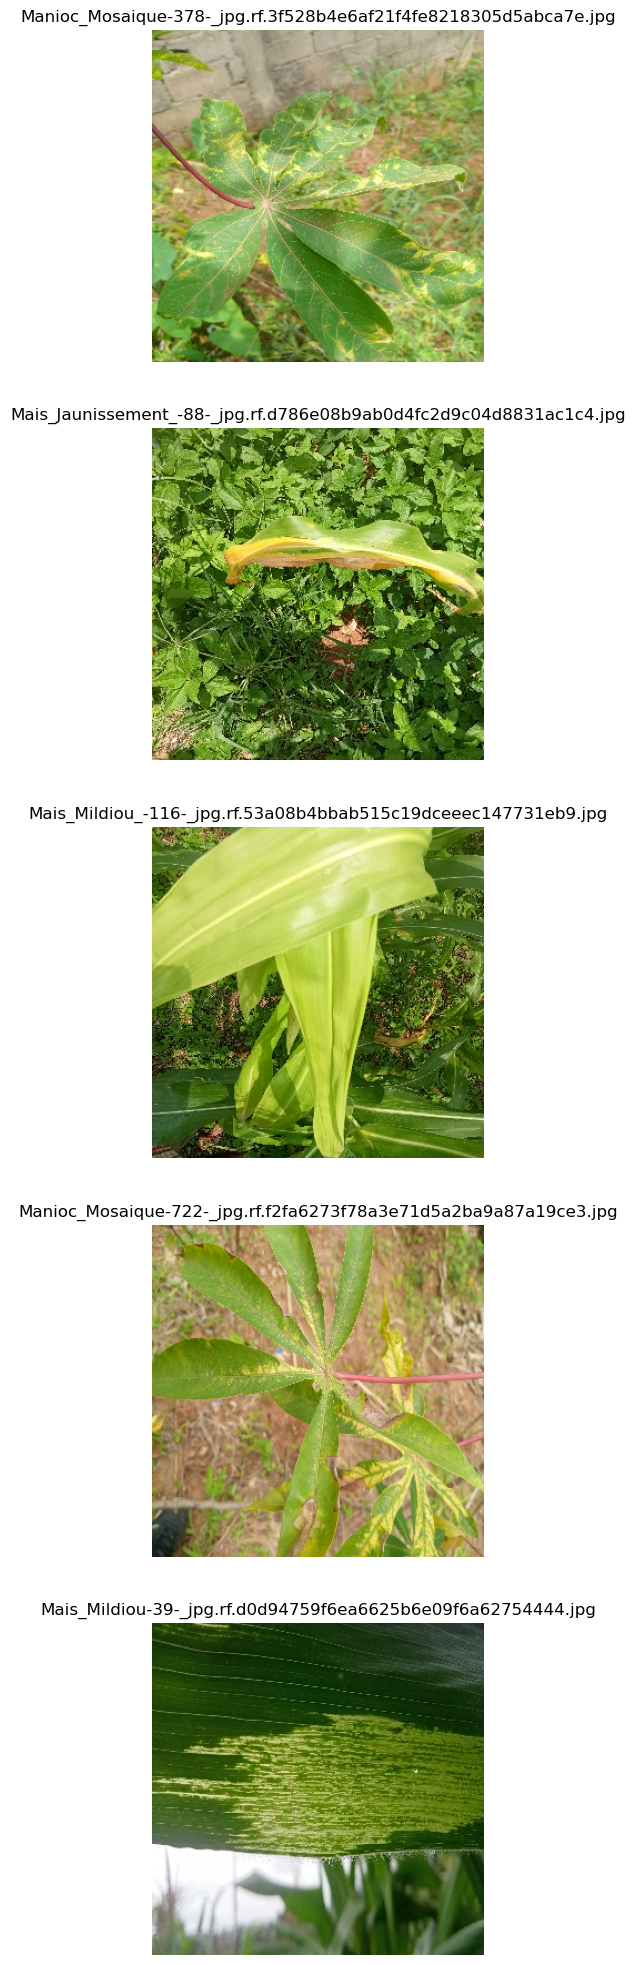

In [126]:
train_ds_filenames = dataset_from_dataframe(train_df, class_names)
val_ds_filenames = dataset_from_dataframe(val_df, class_names)
test_ds_filenames = dataset_from_dataframe(test_df, class_names)

train_ds_filenames = train_ds_filenames.shuffle(train_ds_filenames.cardinality())
val_ds_filenames = val_ds_filenames.shuffle(val_ds_filenames.cardinality())
test_ds_filenames = test_ds_filenames.shuffle(test_ds_filenames.cardinality())

for x, y in train_ds_filenames.take(1):
    print(x)
    print(y)

train_ds_verify = train_ds_filenames.map(lambda x, y: process_dataset(x, y, return_filenames=True) )
verify_dataset(train_ds_verify, num_verify=5)

##### Final Img, Labels datasets
The image/label datasets are created again from the filename datasets.<br>
This time, after already verifying, the filenames are not returned.<br>
The datasets are shuffled entirely, before saving as individual datasets.

In [127]:
train_ds = train_ds_filenames.map(lambda x, y: process_dataset(x, y, return_filenames=False) )
val_ds = val_ds_filenames.map(lambda x, y: process_dataset(x, y, return_filenames=False) )
test_ds = test_ds_filenames.map(lambda x, y: process_dataset(x, y, return_filenames=False) )

train_ds = train_ds.shuffle(buffer_size=train_ds.cardinality())
val_ds = val_ds.shuffle(buffer_size=val_ds.cardinality())
test_ds = test_ds.shuffle(buffer_size=test_ds.cardinality())

train_ds_path = "../data/datasets/filtered_train_ds"
train_ds.save(train_ds_path)

val_ds_path = "../data/datasets/filtered_val_ds"
val_ds.save(val_ds_path)

test_ds_path = "../data/datasets/filtered_test_ds"
test_ds.save(test_ds_path)

2024-08-29 16:53:58.126333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:48: Filling up shuffle buffer (this may take a while): 1383 of 4125
2024-08-29 16:54:08.126696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:48: Filling up shuffle buffer (this may take a while): 2734 of 4125
2024-08-29 16:54:18.126734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:48: Filling up shuffle buffer (this may take a while): 4030 of 4125
2024-08-29 16:54:18.919532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


In [128]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

print(len(train_ds) + len(val_ds) + len(test_ds))

4125
514
515
5154


In [130]:
train_vc = train_df.sum(numeric_only=True).sort_values().to_frame()
train_vc.columns = ["count"]
train_vc["train"] = train_vc["count"] / train_vc["count"].sum()

val_vc = val_df.sum(numeric_only=True).sort_values().to_frame()
val_vc.columns = ["count"]
val_vc["val"] = val_vc["count"] / val_vc["count"].sum()

test_vc = test_df.sum(numeric_only=True).sort_values().to_frame()
test_vc.columns = ["count"]
test_vc["test"] = test_vc["count"] / test_vc["count"].sum()

train_vc.merge(val_vc, left_index=True, right_index=True).merge(test_vc, left_index=True, right_index=True)

,count_x,train,count_y,val,count,test
Corn Violet Decoloration,5,0.001169,0,0.000000,1,0.001873
Corn Purple Discoloration,6,0.001403,1,0.001880,1,0.001873
Corn Smut,10,0.002338,2,0.003759,1,0.001873
Tomato leaf mosaic virus,10,0.002338,2,0.003759,1,0.001873
Corn Yellow Spots,13,0.003039,1,0.001880,2,0.003745
Corn Insects Damages,14,0.003273,2,0.003759,1,0.001873
Cassava Bacterial Blight,18,0.004208,2,0.003759,2,0.003745
Corn Chlorotic Leaf Spot,21,0.004909,2,0.003759,3,0.005618
Corn Gray leaf spot,24,0.005610,3,0.005639,3,0.005618
Corn Mildew,33,0.007714,4,0.007519,4,0.007491
